# BenchFS Time Metrics Overview

このノートブックでは`results/`配下に生成された`time_*.json`を集計し、経過時間やCPU使用率などを可視化します。

In [34]:
from pathlib import Path
import json
import re
import polars as pl
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
from IPython.display import display

plt.rcParams.update({"font.size": 14})
pl.Config.set_tbl_rows(100)

DATA_DIR = (Path.cwd() / "processed" / "time_metrics").resolve()
DATA_DIR.mkdir(parents=True, exist_ok=True)
FIG_DIR = (Path.cwd() / "fig" / "time_metrics").resolve()
FIG_DIR.mkdir(parents=True, exist_ok=True)

def save(fig, name: str) -> None:
    for ext in ("png", "pdf"):
        fig.savefig(FIG_DIR / f"{name}.{ext}", bbox_inches="tight")

def comma_formatter(value, _):
    return f"{value:,.0f}"

def slugify(value: str) -> str:
    cleaned = re.sub(r"[^A-Za-z0-9._-]+", "_", value)
    return cleaned.strip("_") or "unknown"

In [35]:
def resolve_results_root() -> Path:
    candidates = [
        Path("results"),
        Path("..") / "results",
        Path("../..") / "results",
    ]
    for candidate in candidates:
        if candidate.exists():
            return candidate.resolve()
    raise FileNotFoundError("results ディレクトリが見つかりません。ノートブックの位置を確認してください。")

results_root = resolve_results_root()
print(f"Using results directory: {results_root}")

Using results directory: /work/0/NBB/rmaeda/workspace/rust/benchfs/results


In [36]:
def parse_number(value):
    if value is None:
        return None
    if isinstance(value, (int, float)):
        return float(value)
    if isinstance(value, str):
        cleaned = value.replace(",", "").strip()
        if cleaned == "":
            return None
        try:
            return float(cleaned)
        except ValueError:
            return None
    return None

def parse_percent(value):
    if isinstance(value, str) and value.endswith("%"):
        return parse_number(value[:-1])
    return parse_number(value)

def load_time_metrics(root: Path) -> pl.DataFrame:
    numeric_fields = [
        "ElapsedTime(Seconds)",
        "UserCpuSeconds",
        "SystemCpuSeconds",
        "MaxResidentSetSize(KB)",
        "AverageResidentSetSize(KB)",
        "FileSystemInputs",
        "FileSystemOutputs",
        "MinorPageFaults",
        "MajorPageFaults",
        "VoluntaryContextSwitches",
        "InvoluntaryContextSwitches",
        "Swaps",
        "SocketMessagesSent",
        "SocketMessagesReceived",
    ]
    records = []
    for path in sorted(root.glob("**/time_*.json")):
        try:
            raw = json.loads(path.read_text())
        except json.JSONDecodeError as exc:
            print(f"⚠️ JSON parse error in {path}: {exc}")
            continue
        rel_parts = path.relative_to(root).parts
        try:
            time_index = int(path.stem.split("_")[1])
        except (IndexError, ValueError):
            time_index = None
        record = {
            "time_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": rel_parts[2] if len(rel_parts) > 2 else "",
            "time_index": time_index,
            "Command": raw.get("Command", ""),
        }
        for field in numeric_fields:
            record[field] = parse_number(raw.get(field))
        record["CpuUsagePercent"] = parse_percent(raw.get("CpuUsage"))
        record["ElapsedTime"] = raw.get("ElapsedTime")
        records.append(record)
    if not records:
        return pl.DataFrame([])
    df = pl.DataFrame(records)
    if "ElapsedTime(Seconds)" in df.columns:
        df = df.rename({"ElapsedTime(Seconds)": "ElapsedTimeSeconds"})
    df = df.sort(["experiment", "run", "time_index"])
    return df

def load_ior_metrics(root: Path) -> pl.DataFrame:
    ior_pattern = re.compile(r"ior_result_(\d+)\.txt$")
    records = []
    for path in sorted(root.glob("**/ior_results/ior_result_*.txt")):
        match = ior_pattern.search(path.name)
        run_index = int(match.group(1)) if match else None
        rel_parts = path.relative_to(root).parts
        command_line = None
        try:
            lines = path.read_text(errors="ignore").splitlines()
        except OSError as exc:
            print(f"⚠️ Could not read {path}: {exc}")
            continue
        base_record = {
            "ior_file": str(path.relative_to(root)),
            "collection": "/".join(rel_parts[:-1]),
            "backend": rel_parts[0] if len(rel_parts) > 0 else "",
            "experiment": rel_parts[1] if len(rel_parts) > 1 else "",
            "run": rel_parts[2] if len(rel_parts) > 2 else "",
            "run_index": run_index,
        }
        in_results = False
        for line in lines:
            if line.startswith("Command line"):
                command_line = line.split(":", 1)[1].strip()
            if line.startswith("Results"):
                in_results = True
                continue
            if in_results and line.startswith("Summary of all tests"):
                break
            if not in_results:
                continue
            stripped = line.strip()
            if not stripped or stripped.startswith("access") or stripped.startswith("------"):
                continue
            parts = stripped.split()
            if parts[0] not in {"write", "read"}:
                continue
            if len(parts) < 11:
                continue
            record = base_record | {
                "Command": command_line or "",
                "operation": parts[0],
                "bandwidth_mib_s": parse_number(parts[1]),
                "iops": parse_number(parts[2]),
                "latency_seconds": parse_number(parts[3]),
                "block_kib": parse_number(parts[4]),
                "xfer_kib": parse_number(parts[5]),
                "open_seconds": parse_number(parts[6]),
                "transfer_seconds": parse_number(parts[7]),
                "close_seconds": parse_number(parts[8]),
                "total_seconds": parse_number(parts[9]),
                "iteration": parse_number(parts[10]),
            }
            record["bandwidth_gib_s"] = (record["bandwidth_mib_s"] / 1024.0) if record["bandwidth_mib_s"] is not None else None
            records.append(record)
    if not records:
        return pl.DataFrame([])
    df = pl.DataFrame(records)
    df = df.sort(["experiment", "run", "operation"])
    return df

time_df = load_time_metrics(results_root)
if time_df.is_empty():
    print("No time_*.json files found under results.")
else:
    display(time_df.head().to_pandas())

ior_df = load_ior_metrics(results_root)
if ior_df.is_empty():
    print("No ior_result_*.txt files found under results.")
else:
    display(ior_df.head().to_pandas())

⚠️ JSON parse error in /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.10.27-22.20.56-default/2025.10.27-22.21.11-227953.nqsv-2/time_14.json: Expecting value: line 1 column 1 (char 0)
⚠️ JSON parse error in /work/0/NBB/rmaeda/workspace/rust/benchfs/results/benchfs/2025.10.27-22.27.59-default/2025.10.27-22.52.00-227957.nqsv-4/time_14.json: Expecting value: line 1 column 1 (char 0)


,time_file,collection,backend,experiment,run,time_index,Command,ElapsedTimeSeconds,UserCpuSeconds,SystemCpuSeconds,...,FileSystemOutputs,MinorPageFaults,MajorPageFaults,VoluntaryContextSwitches,InvoluntaryContextSwitches,Swaps,SocketMessagesSent,SocketMessagesReceived,CpuUsagePercent,ElapsedTime
0,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,0,mpirun --leave-session-attached -hostfile /var...,0.90,0.20,0.34,...,16720.0,84090.0,2648.0,1414.0,112.0,0.0,0.0,0.0,60.0,0:00.90
1,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,1,mpirun --leave-session-attached -hostfile /var...,0.96,0.11,0.45,...,16720.0,84126.0,2612.0,1407.0,117.0,0.0,0.0,0.0,59.0,0:00.96
2,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,2,mpirun --leave-session-attached -hostfile /var...,1.04,0.19,0.46,...,16720.0,93974.0,2612.0,1370.0,114.0,0.0,0.0,0.0,63.0,0:01.04
3,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,3,mpirun --leave-session-attached -hostfile /var...,1.03,0.19,0.46,...,16720.0,94742.0,2612.0,1373.0,114.0,0.0,0.0,0.0,63.0,0:01.03
4,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,4,mpirun --leave-session-attached -hostfile /var...,1.21,0.25,0.59,...,16728.0,127315.0,2613.0,1381.0,118.0,0.0,0.0,0.0,70.0,0:01.21


,ior_file,collection,backend,experiment,run,run_index,Command,operation,bandwidth_mib_s,iops,latency_seconds,block_kib,xfer_kib,open_seconds,transfer_seconds,close_seconds,total_seconds,iteration,bandwidth_gib_s
0,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,4,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,read,1555.07,1555.78,0.001194,65536.0,1024.0,0.000954,0.082274,0.004938,0.082311,0.0,1.518623
1,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,0,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,read,933.39,937.54,0.001795,4096.0,1024.0,0.001007,0.008533,0.000383,0.008571,0.0,0.911514
2,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,9,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,read,1652.72,413.99,0.004332,16384.0,4096.0,0.000840,0.019324,0.001192,0.019362,0.0,1.613984
3,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,1,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,read,911.16,915.14,0.001833,4096.0,1024.0,0.001028,0.008742,0.000418,0.008780,0.0,0.889805
4,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs/2025.10.27-22.20.56-default/2025.10.27...,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,8,/work/0/NBB/rmaeda/workspace/rust/benchfs/ior_...,read,1705.59,427.31,0.004251,16384.0,4096.0,0.000862,0.018722,0.000898,0.018762,0.0,1.665615


## 集計サマリー

各実験×実行ごとに主要な統計量を集計します。

In [37]:
if time_df.is_empty():
    print("No summaries to show.")
else:
    summary = (
        time_df.group_by(["backend", "experiment", "run"], maintain_order=True)
        .agg(
            pl.len().alias("samples"),
            pl.col("ElapsedTimeSeconds").mean().alias("elapsed_mean"),
            pl.col("ElapsedTimeSeconds").std().alias("elapsed_std"),
            pl.col("ElapsedTimeSeconds").min().alias("elapsed_min"),
            pl.col("ElapsedTimeSeconds").max().alias("elapsed_max"),
            pl.col("CpuUsagePercent").mean().alias("cpu_mean"),
            pl.col("MaxResidentSetSize(KB)").max().alias("rss_max"),
        )
        .sort(["backend", "experiment", "run"])
    )
    display(summary.to_pandas())

,backend,experiment,run,samples,elapsed_mean,elapsed_std,elapsed_min,elapsed_max,cpu_mean,rss_max
0,benchfs,2025.10.27-22.20.56-default,2025.10.27-22.21.11-227953.nqsv-2,14,1.397857,0.942820,0.90,3.61,55.928571,397096.0
1,benchfs,2025.10.27-22.27.59-default,2025.10.27-22.52.00-227957.nqsv-4,14,1.480000,0.924313,0.97,3.66,56.071429,396912.0
2,benchfs,2025.10.27-22.27.59-default,2025.10.27-23.23.34-227958.nqsv-8,6,1.321667,0.260877,1.09,1.66,66.000000,390784.0


## Elapsed Time Visualization

実験ごとの経過時間分布を棒グラフで表示します。

run,2025.10.27-22.21.11-227953.nqsv-2
time_index,
0,0.90
1,0.96
2,1.04
3,1.03
4,1.21
5,1.20
6,0.91
7,0.91
8,0.98


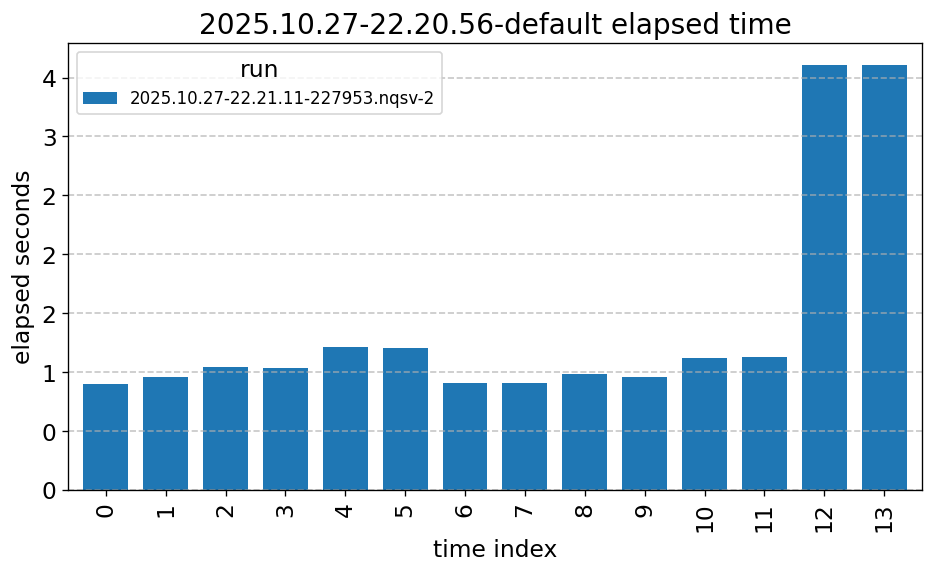

run,2025.10.27-22.52.00-227957.nqsv-4,2025.10.27-23.23.34-227958.nqsv-8
time_index,,
0,1.01,1.18
1,1.07,1.09
2,1.09,1.15
3,1.14,1.20
4,1.42,1.66
5,1.35,1.65
6,0.97,NaN
7,1.01,NaN
8,1.01,NaN


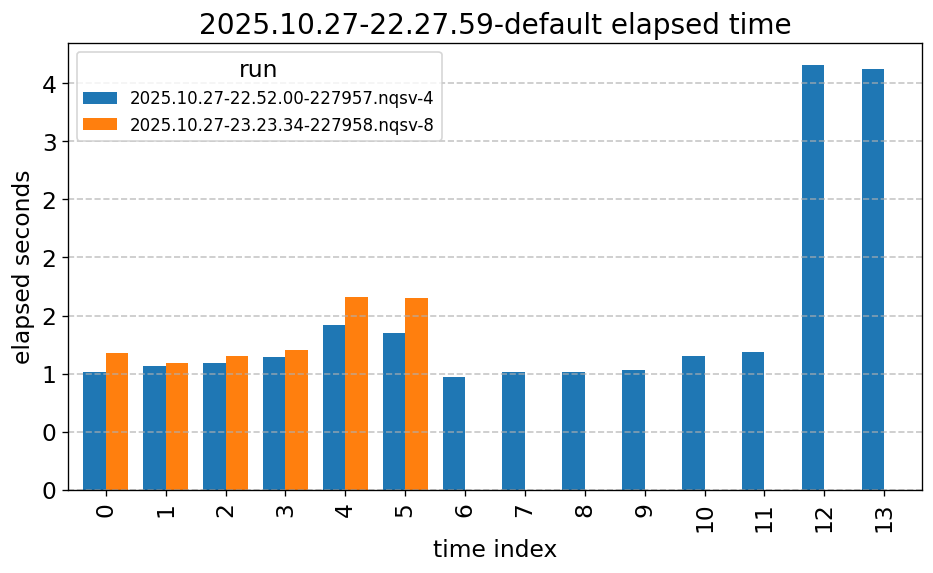

In [38]:
if time_df.is_empty():
    print("No data to plot.")
else:
    plot_df = time_df.filter(pl.col("ElapsedTimeSeconds").is_not_null())
    if plot_df.is_empty():
        print("ElapsedTimeSeconds is missing in all records.")
    else:
        for experiment_df in plot_df.partition_by("experiment", maintain_order=True):
            experiment = experiment_df[0, "experiment"] or "unknown"
            tidy = (
                experiment_df
                .drop_nulls(["time_index", "run", "ElapsedTimeSeconds"])
                .with_columns(
                    pl.col("time_index").cast(pl.Int64)
                )
                .select("time_index", "run", "ElapsedTimeSeconds")
                .to_pandas()
            )
            if tidy.empty:
                continue
            pivot = (
                tidy.pivot_table(
                    index="time_index",
                    columns="run",
                    values="ElapsedTimeSeconds",
                    aggfunc="mean",
                )
                .sort_index()
            )
            display(pivot)
            fig, ax = plt.subplots(figsize=(8, 5), dpi=120)
            pivot.plot(kind="bar", ax=ax, width=0.75)
            ax.set_xlabel("time index")
            ax.set_ylabel("elapsed seconds")
            ax.set_title(f"{experiment} elapsed time")
            ax.grid(axis="y", alpha=0.7, linestyle="--", linewidth=1)
            ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
            ax.legend(title="run", fontsize=10)
            plt.tight_layout()
            save(fig, f"elapsed_time_{slugify(experiment)}")
            plt.show()
            plt.close(fig)

## CPU vs Memory

CPU使用率と最大RSSの関係を散布図で確認します。

/tmp/ipykernel_3141354/3824398689.py:22: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed in 3.11. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap()`` or ``pyplot.get_cmap()`` instead.
  colors = plt.cm.get_cmap("tab10").colors


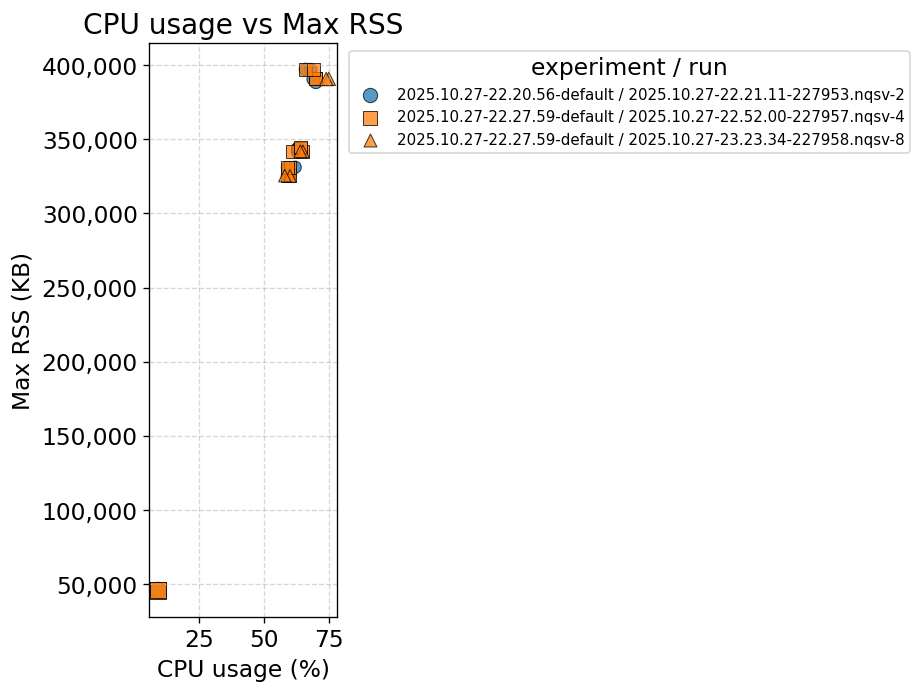

In [39]:
if time_df.is_empty():
    print("No data to plot.")
else:
    scatter_df = time_df.filter(
        pl.col("CpuUsagePercent").is_not_null()
        & pl.col("MaxResidentSetSize(KB)").is_not_null()
        & pl.col("ElapsedTimeSeconds").is_not_null()
    )
    if scatter_df.is_empty():
        print("必要な列を持つレコードがありません。")
    else:
        pdf = scatter_df.select(
            "experiment",
            "run",
            "CpuUsagePercent",
            pl.col("MaxResidentSetSize(KB)").alias("MaxRSS"),
            "ElapsedTimeSeconds",
        ).to_pandas()
        pdf["point_size"] = 40 + 15 * pdf["ElapsedTimeSeconds"]
        experiments = {value: idx for idx, value in enumerate(pdf["experiment"].astype(str).unique())}
        runs = {value: idx for idx, value in enumerate(pdf["run"].astype(str).unique())}
        colors = plt.cm.get_cmap("tab10").colors
        markers = ["o", "s", "^", "D", "P", "X", "v", "<", ">", "*"]
        fig, ax = plt.subplots(figsize=(8, 6), dpi=120)
        for (experiment, run), group in pdf.groupby(["experiment", "run"], dropna=False):
            label = f"{experiment} / {run}"
            color = colors[experiments[str(experiment)] % len(colors)]
            marker = markers[runs[str(run)] % len(markers)]
            ax.scatter(
                group["CpuUsagePercent"],
                group["MaxRSS"],
                s=group["point_size"],
                c=[color],
                marker=marker,
                alpha=0.75,
                linewidths=0.6,
                edgecolors="black",
                label=label,
            )
        ax.set_xlabel("CPU usage (%)")
        ax.set_ylabel("Max RSS (KB)")
        ax.set_title("CPU usage vs Max RSS")
        ax.grid(alpha=0.5, linestyle="--", linewidth=0.8)
        ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
        handles, labels = ax.get_legend_handles_labels()
        ax.legend(handles, labels, bbox_to_anchor=(1.02, 1), loc="upper left", title="experiment / run", fontsize=9)
        plt.tight_layout()
        save(fig, "cpu_vs_memory")
        plt.show()
        plt.close(fig)

## IOR Bandwidth Summary

IOR結果を取り込み、操作種別ごとの帯域などを集計します。

In [40]:
if ior_df.is_empty():
    print("No IOR results to summarize.")
else:
    ior_summary = (
        ior_df
        .with_columns(
            pl.col("block_kib").cast(pl.Int64),
            pl.col("xfer_kib").cast(pl.Int64),
        )
        .group_by(["backend", "experiment", "run", "operation", "block_kib", "xfer_kib"], maintain_order=True)
        .agg(
            pl.len().alias("samples"),
            pl.col("bandwidth_mib_s").mean().alias("bandwidth_mib_mean"),
            pl.col("bandwidth_mib_s").max().alias("bandwidth_mib_max"),
            pl.col("bandwidth_mib_s").min().alias("bandwidth_mib_min"),
            pl.col("latency_seconds").mean().alias("latency_mean"),
        )
        .with_columns(
            (pl.col("bandwidth_mib_mean") / 1024.0).alias("bandwidth_gib_mean"),
            pl.format("blk {0} KiB / xfer {1} KiB", pl.col("block_kib"), pl.col("xfer_kib")).alias("config"),
        )
        .sort(["backend", "experiment", "run", "operation", "block_kib", "xfer_kib"])
    )
    display(ior_summary.to_pandas())

ValueError: number of placeholders should equal the number of arguments

## Bandwidth Visualization

実験ごとに操作別の帯域グラフを描画し、画像として保存します。

/tmp/ipykernel_3141354/2885369994.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  experiment_df


,read,write
run,,
2025.10.27-22.21.11-227953.nqsv-2,1384.046667,497.821667


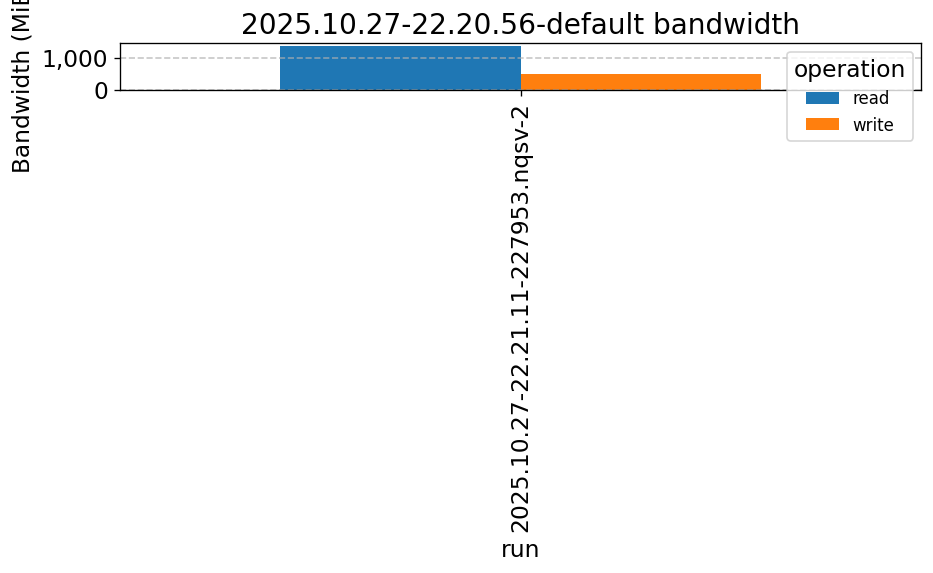

/tmp/ipykernel_3141354/2885369994.py:7: DeprecationWarning: the argument `columns` for `DataFrame.pivot` is deprecated. It was renamed to `on` in version 1.0.0.
  experiment_df


,read,write
run,,
2025.10.27-22.52.00-227957.nqsv-4,1970.1075,837.479167


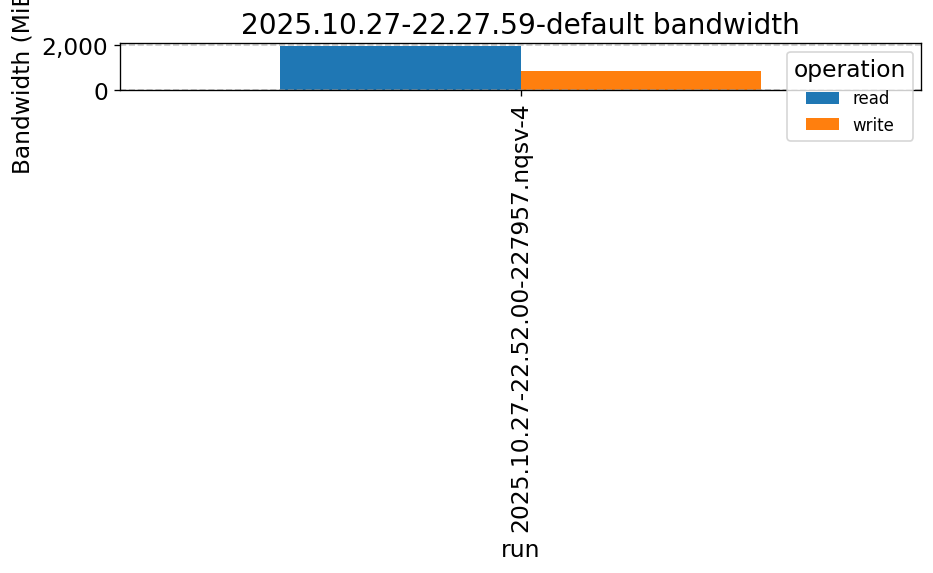

In [ ]:
if ior_df.is_empty():
    print("No IOR data to plot.")
else:
    for experiment_df in ior_df.partition_by("experiment", maintain_order=True):
        experiment = experiment_df[0, "experiment"] or "unknown"
        for run_df in experiment_df.partition_by("run", maintain_order=True):
            run = run_df[0, "run"] or "unknown"
            tidy = (
                run_df
                .with_columns(
                    pl.col("block_kib").cast(pl.Int64),
                    pl.col("xfer_kib").cast(pl.Int64),
                    pl.format("blk {0} KiB / xfer {1} KiB", pl.col("block_kib"), pl.col("xfer_kib")).alias("config"),
                )
                .group_by(["config", "operation"], maintain_order=True)
                .agg(pl.col("bandwidth_mib_s").mean())
                .pivot(values="bandwidth_mib_s", index="config", columns="operation")
                .sort("config")
            )
            if tidy.is_empty():
                continue
            pdf = tidy.to_pandas().set_index("config")
            display(pdf)
            fig, ax = plt.subplots(figsize=(9, 5), dpi=120)
            pdf.plot(kind="bar", ax=ax, width=0.7)
            ax.set_xlabel("block / transfer size")
            ax.set_ylabel("Bandwidth (MiB/s)")
            ax.set_title(f"{experiment} / {run} bandwidth")
            ax.grid(axis="y", alpha=0.7, linestyle="--", linewidth=1)
            ax.yaxis.set_major_formatter(FuncFormatter(comma_formatter))
            ax.legend(title="operation", fontsize=10)
            plt.xticks(rotation=45, ha="right")
            plt.tight_layout()
            save(fig, f"bandwidth_{slugify(experiment)}_{slugify(run)}")
            plt.show()
            plt.close(fig)

## Export Processed IOR JSON

解析済みデータをJSONとして保存し、外部ツールから再利用できるようにします。

In [ ]:
if ior_df.is_empty():
    print("No IOR results to export.")
else:
    json_out = DATA_DIR / "ior_bandwidth_raw.json"
    json_out.parent.mkdir(parents=True, exist_ok=True)
    json_out.write_text(
        json.dumps(ior_df.to_pandas().to_dict(orient="records"), ensure_ascii=False, indent=2)
    )
    summary_out = DATA_DIR / "ior_bandwidth_summary.json"
    summary_records = (
        ior_df
        .with_columns(
            pl.col("block_kib").cast(pl.Int64),
            pl.col("xfer_kib").cast(pl.Int64),
        )
        .group_by(["backend", "experiment", "run", "operation", "block_kib", "xfer_kib"], maintain_order=True)
        .agg(
            pl.len().alias("samples"),
            pl.col("bandwidth_mib_s").mean().alias("bandwidth_mib_mean"),
            pl.col("bandwidth_mib_s").max().alias("bandwidth_mib_max"),
            pl.col("bandwidth_mib_s").min().alias("bandwidth_mib_min"),
            pl.col("latency_seconds").mean().alias("latency_mean"),
        )
        .with_columns(
            (pl.col("bandwidth_mib_mean") / 1024.0).alias("bandwidth_gib_mean"),
            pl.format("blk {0} KiB / xfer {1} KiB", pl.col("block_kib"), pl.col("xfer_kib")).alias("config"),
        )
        .sort(["backend", "experiment", "run", "operation", "block_kib", "xfer_kib"])
        .to_pandas()
        .to_dict(orient="records")
    )
    summary_out.write_text(json.dumps(summary_records, ensure_ascii=False, indent=2))
    print(f"Wrote {json_out}")
    print(f"Wrote {summary_out}")

Wrote /work/0/NBB/rmaeda/workspace/rust/benchfs/plot/processed/time_metrics/ior_bandwidth.json
